# 1. 라이브러리 및 환경설정 

## 1.1 라이브러리 임포트

In [614]:
!pip install libpysal
!pip install matplotlib_scalebar
!pip install spaghetti
!pip install ortools
!pip install gurobipy

In [615]:
from collections import OrderedDict
from libpysal import cg, examples
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar
from ortools.linear_solver import pywraplp
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import font_manager, rc

import geopandas
import libpysal
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd

import geopandas as gpd
import matplotlib_scalebar
import numpy as np
import ortools
import seaborn as sns
import shapely
import spaghetti
import sys
import os


# 모델링 관련
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
from PIL import Image

In [616]:
try:
    from IPython.display import Markdown as md
except ImportError:
    pass

## 1.2 표현 형식 변경

In [617]:
matplotlib.rcParams['axes.unicode_minus'] = False 
matplotlib.rcParams['font.family'] = "NanumGothic"

In [618]:
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)

In [619]:
# 한글폰트
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False 

# 2. 데이터 전처리 및 EDA

## 2.1 데이터 로드

In [620]:
file_path = './제출용/jupyter/dataset/'

In [621]:
# 제공 데이터
df_1 = pd.read_csv(file_path + '1.수원시_112신고이력(격자_관할경계매핑).csv')
df_2 = gpd.read_file(file_path + '2.수원시_112신고(격자별 신고횟수).geojson')
df_3 = pd.read_csv(file_path + '3.3개시도_112신고이력(관할경계매핑).csv')
df_4 = pd.read_csv(file_path + '4.수원시_시간대별_유동인구(2020).csv')
df_5 = pd.read_csv(file_path + '5.수원시_성연령별_유동인구(2020).csv')
df_6 = pd.read_csv(file_path + '6.수원시_요일별_유동인구(2020).csv')
df_8 = gpd.read_file(file_path + '8.4개시도_유흥업소현황.geojson')
df_9 = gpd.read_file(file_path + '9.4개시도_용도지역도.geojson')
df_10 = gpd.read_file(file_path + '10.4개시도_사업지구경계도.geojson')
df_11 = gpd.read_file(file_path + '11.4개시도_경찰서_관할경계.geojson')
df_12 = gpd.read_file(file_path + '12.4개시도_치안안전센터_관할경계.geojson')
df_21 = pd.read_csv(file_path + '21.수원시_가로등현황.csv')
df_22 = pd.read_csv(file_path + '22.4개시도_보안등현황.csv')
df_24 = pd.read_csv(file_path + '24.4개시도_CCTV설치현황.csv')
df_27 = pd.read_csv(file_path + '27.4개시도_공원현황.csv')
df_33 = pd.read_csv(file_path + '33.4개시도_1인가구수.csv')

# 추가 데이터
df_01 = pd.read_csv(file_path + '6.범죄발생연표.csv')

C:\ProgramData\Anaconda3\envs\compas_suwon\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\ProgramData\Anaconda3\envs\compas_suwon\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## 2.2 전처리 함수 정의

In [622]:
# 날짜형 변환
def df_datetime(df, column):
    df[column] = df[column].astype('str')
    df[column] = pd.to_datetime(df[column])
    
def groupby_count(df, groupby, count, sort, figsize=(6,4), rotation=0, title=''):
    plt.figure(figsize = figsize)
    plt.xticks(rotation = rotation)
    plt.title('{}별 {} 건수'.format(groupby, title))
    df_graph = df.groupby(groupby).count().reset_index().sort_values(by=sort, ascending=False)
    chart = sns.barplot(x = df_graph[groupby], y=df_graph[count])
    return chart

def groupby_count_r(df, groupby, count, sort, figsize=(6,4), rotation=0, title=''):
    plt.figure(figsize = figsize)
    plt.xticks(rotation = rotation)
    plt.title('{}별 {} 건수'.format(groupby, title))
    df_graph = df.groupby(groupby).count().reset_index().sort_values(by=sort)
    chart = sns.lineplot(x = df_graph[groupby], y=df_graph[count])
    return chart

def groupby_sum(df, groupby, total, sort, figsize=(6,4), rotation=0, title=''):
    plt.figure(figsize =figsize)
    plt.xticks(rotation = rotation)
    plt.title('{}별 {} 합계'.format(groupby, title))
    df_graph = df.groupby(groupby).sum().reset_index().sort_values(by=sort, ascending=False)
    chart = sns.barplot(x = df_graph[groupby], y=df_graph[total])
    return chart

## 2.3 데이터 전처리, 시각화

#### 추가데이터 01. 범죄발생원표

In [623]:
# 데이터 전처리
# 공백 제거
df_01['jur_stn'] = df_01['jur_stn'].apply(lambda x: x.strip())
df_01['crm_tm'] = df_01['crm_tm'].apply(lambda x: x.strip())

# sgg열 생성
def sgg(x):
    for i in x:
        if x[0:2]=='경남':
            if x=='경남진주경찰서':
                return '진주'
            else:
                return '창원'
        elif x[0:2]=='서울':
            return '서울'
        elif x[0:2]=='경기':
            return '수원'
        else:
            return '충남' 
df_01[['sgg_nm']] = df_01[['jur_stn']].applymap(sgg)

# 충남 데이터 제거
df_01 = df_01[df_01['sgg_nm']!='충남']

# 5대 범죄 제외 데이터 제거
df_01 = df_01[df_01['5m_crm_yn']!=' ']

# 표현형식 통일
df_01['crm_tm'] = df_01['crm_tm'].apply(lambda x: x.replace('∼', '~'))

<AxesSubplot:title={'center':'sgg_nm별 범죄 건수'}, xlabel='sgg_nm', ylabel='jur_stn'>

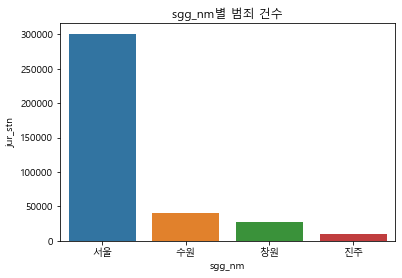

In [624]:
groupby_count(df_01, 'sgg_nm', 'jur_stn', sort='jur_stn', title='범죄')

<AxesSubplot:title={'center':'4개시 인구수대비 범죄수(2017~2019)'}, ylabel='ratio'>

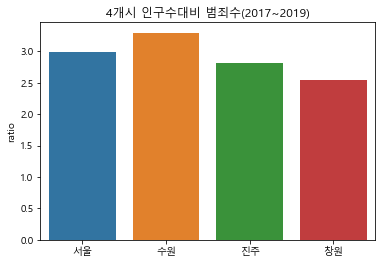

In [625]:
plt.figure(figsize=(6,4))
plt.title('4개시 인구수대비 범죄수(2017~2019)')
df_graph = pd.DataFrame(columns = ['ratio'], index=['서울', '수원', '진주', '창원'], data=[2.99, 3.3, 2.81, 2.55])

# 4개시 인구수대비 범죄수
sns.barplot(x=df_graph.index, y=df_graph['ratio'])

In [626]:
def ppt(region):
    plt.figure(figsize = (5,5))
    df_graph = df_01[df_01['sgg_nm']==region]
    df_01['5m_crm_yn'] = df_01['5m_crm_yn'].apply(lambda x:'살인 및 강도' if (x=='살인') or (x=='강도') else x)
    
    plt.title("{}시 5대범죄 범죄건수 비율".format(region))
    df_pie = df_graph['5m_crm_yn'].value_counts()
    df_pie.plot.pie(autopct='%.2f%%')

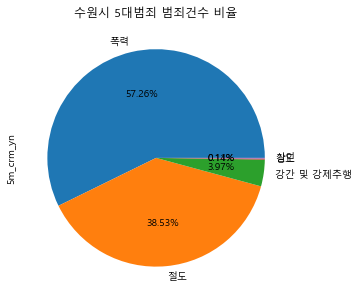

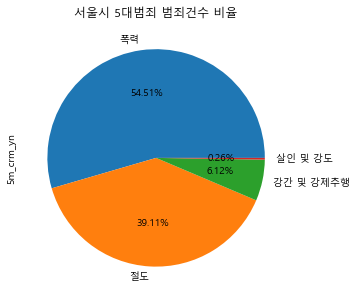

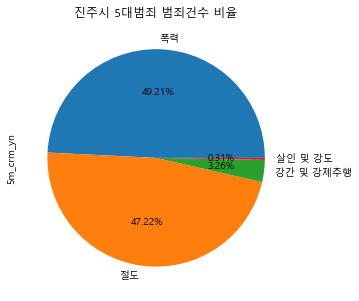

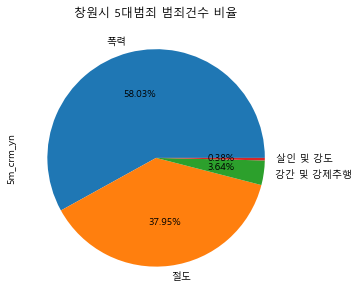

In [627]:
ppt('수원')
ppt('서울')
ppt('진주')
ppt('창원')

In [628]:
# 경찰서별 5대범죄 파일 생성
df_series = df_01['jur_stn'].value_counts()
df_tomerge = df_series.to_frame(name='COUNT').reset_index()
df_tomerge.columns = ['NAME', 'COUNT']

# 이름 통일
df_tomerge['NAME'] = df_tomerge['NAME'].apply(lambda x:x.replace('경남', '').replace('경기', ''))

# merge
df_merge = pd.merge(df_11, df_tomerge, on='NAME')

# 저장
df_merge.to_file('./dataset/경찰서별 5대 범죄.geojson', encoding = 'utf-8', index= False)

<AxesSubplot:title={'center':'crm_tm별 수원시 5대 범죄 건수'}, xlabel='crm_tm', ylabel='Unnamed: 0'>

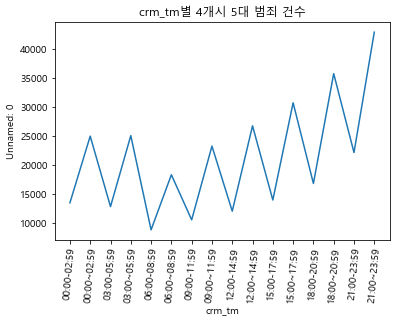

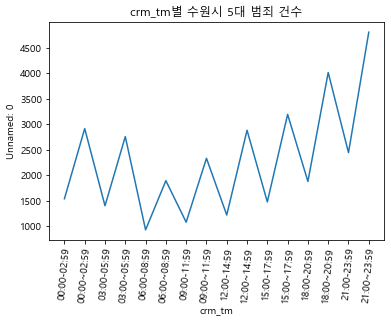

In [629]:
df_graph = df_01[df_01['crm_tm']!='미상']
df_graph_sw = df_graph[df_graph['sgg_nm']=='수원']

# 시간별 4개시 5대 범죄 건수
groupby_count_r(df_graph, 'crm_tm', 'Unnamed: 0', sort='crm_tm', rotation=85, title='4개시 5대 범죄')
# 시간별 수원시 5대 범죄 건수
groupby_count_r(df_graph_sw, 'crm_tm', 'Unnamed: 0', sort='crm_tm', rotation=85, title='수원시 5대 범죄')

#### 수원시_112신고이력(격자_관할경계매핑)

In [630]:
df_1.head()

,Unnamed: 0,﻿case_type,rec_date,rec_time,arrival_date,gid,name,psname
0,0,비상벨,20200101,183945',NaN,다사56aa19ab,고등파출소,수원서부경찰서
1,1,기타_타기관,20200101,012615',20200101014135.00000,다사58ab18ba,인계파출소,수원남부경찰서
2,2,폭력,20200101,005151',20200101005314.00000,다사56bb21aa,화서문지구대,수원중부경찰서
3,3,소음,20200101,012608',20200101013131.00000,다사57aa17ba,세류지구대,수원남부경찰서
4,4,분실습득,20200101,014719',NaN,다사59bb21aa,광교지구대,수원남부경찰서


In [631]:
# rec_date 날짜형 변환
df_datetime(df_1, 'rec_date')

# month열 생성
df_1['rec_month'] = df_1['rec_date'].dt.month
df_1['rec_weekday'] = df_1['rec_date'].dt.dayofweek

<AxesSubplot:title={'center':'rec_date별  건수'}, xlabel='rec_date', ylabel='name'>

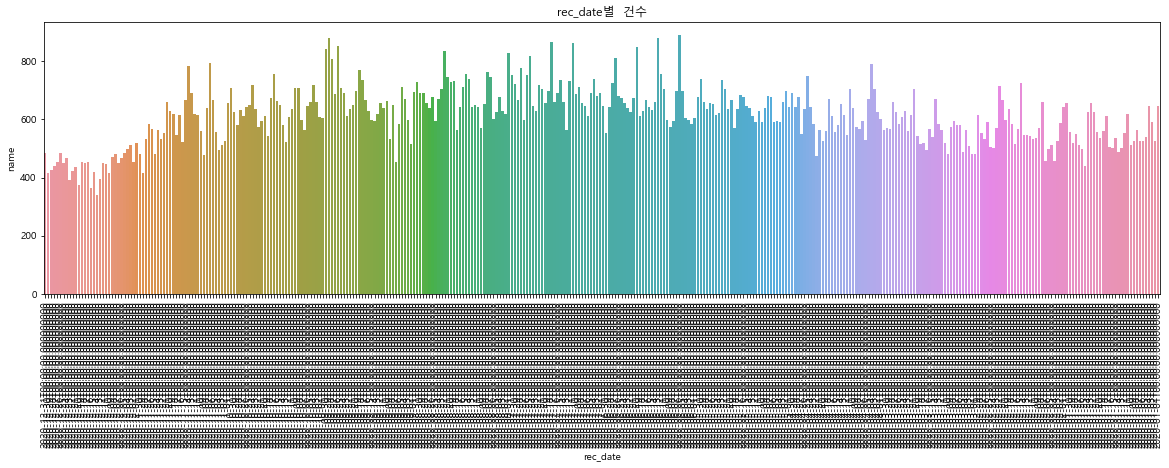

In [632]:
groupby_count(df_1, 'rec_date', 'name', 'rec_date', (20,5), 90)

<AxesSubplot:title={'center':'rec_date별 112 신고 건수'}, xlabel='rec_date', ylabel='name'>

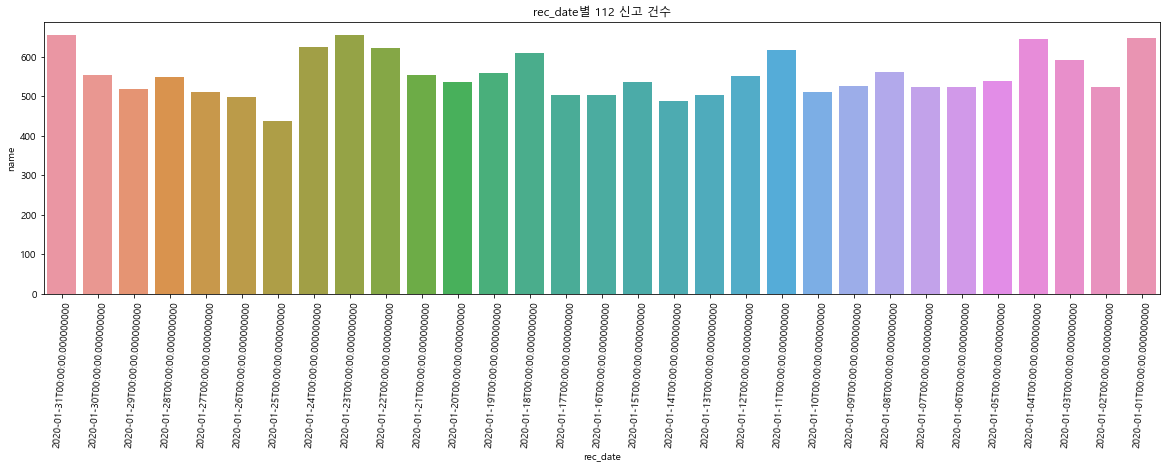

In [633]:
groupby_count(df_1[df_1['rec_month']==1], 'rec_date', 'name', 'rec_date', figsize=(20,5), rotation=86, title='112 신고')

<AxesSubplot:title={'center':'rec_weekday별 112 신고 건수'}, xlabel='rec_weekday', ylabel='name'>

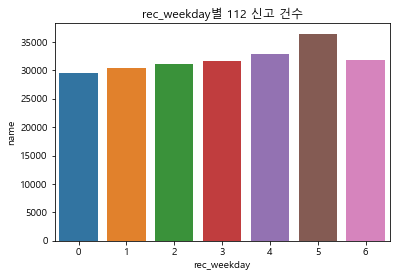

In [634]:
groupby_count(df_1, 'rec_weekday', 'name', 'rec_weekday',  title='112 신고')

0 - 월요일, 6 - 일요일

<AxesSubplot:title={'center':'rec_month별 112 신고 건수'}, xlabel='rec_month', ylabel='name'>

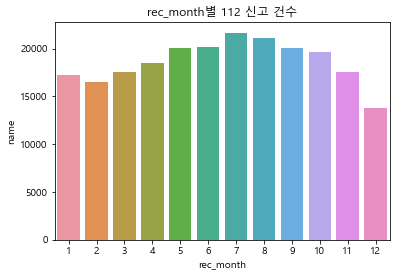

In [635]:
groupby_count(df_1, 'rec_month', 'name', 'rec_month', title='112 신고')

In [636]:
# columns 정리
df_1.columns = ['Unnamed: 0', 'case_type', 'rec_date', 'rec_time', 'arrival_date',
       'gid', 'name', 'psname', 'rec_month', 'rec_weekday']

<AxesSubplot:title={'center':'case_type별 112 신고 건수'}, xlabel='case_type', ylabel='name'>

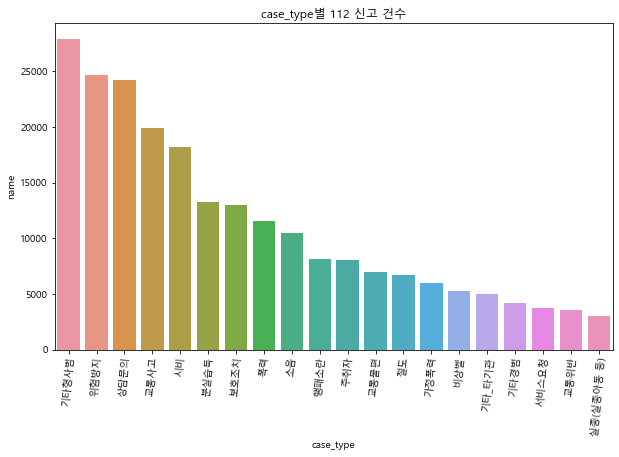

In [637]:
groupby_count(df_1, 'case_type', 'name', sort='name', figsize=(10,6), rotation=85, title='112 신고')

#### 월별 112 항목별 신고 건수

<AxesSubplot:title={'center':'rec_month별 폭력 112 신고 건수'}, xlabel='rec_month', ylabel='name'>

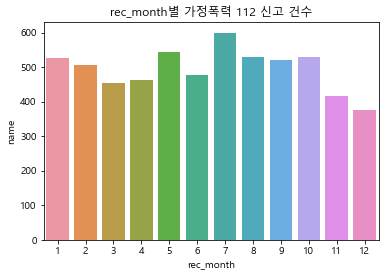

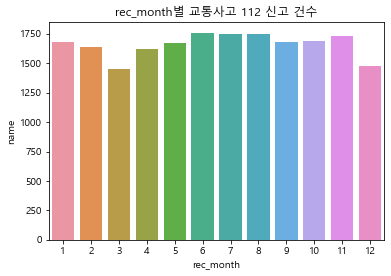

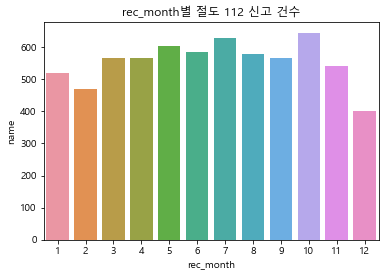

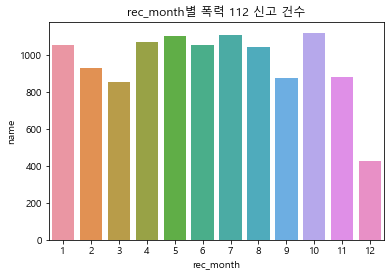

In [638]:
groupby_count(df_1[df_1['case_type']=='가정폭력'], 'rec_month', 'name', sort='name', title='가정폭력 112 신고')
groupby_count(df_1[df_1['case_type']=='교통사고'], 'rec_month', 'name', sort='name', title='교통사고 112 신고')
groupby_count(df_1[df_1['case_type']=='절도'], 'rec_month', 'name',  sort='name',title='절도 112 신고')
groupby_count(df_1[df_1['case_type']=='폭력'], 'rec_month', 'name', sort='name', title='폭력 112 신고')

#### 3개시도_112신고이력(관할경계매핑)

In [639]:
#3.3개시도_112신고이력(관할경계매핑)
df_3.head()

,Unnamed: 0,case_type,rec_date,rec_time,arrival_date,name,psname
0,0,위험방지,20200101,000141',20200101001115,비봉지구대,진주경찰서
1,1,소음,20200101,004826',20200101004950,비봉지구대,진주경찰서
2,2,교통위반,20200101,014339',20200101015133,개양파출소,진주경찰서
3,3,위험방지,20200101,023507',20200101023915,개양파출소,진주경찰서
4,4,위험방지,20200101,005003',20200101005019,비봉지구대,진주경찰서


In [640]:
df_3['sggname'] = df_3['psname'].apply(lambda x: '서울' if x[0:2]=='서울' else ('진주' if x[0:2]=='진주' else '창원'))

<AxesSubplot:title={'center':'sggname별 112 신고 건수'}, xlabel='sggname', ylabel='name'>

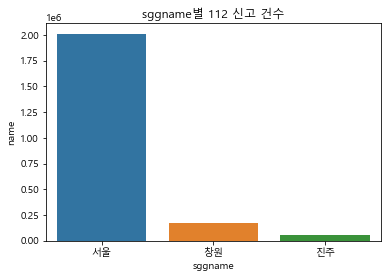

In [641]:
# 시군구
groupby_count(df_3, 'sggname', 'name', sort='name', title='112 신고')

<AxesSubplot:title={'center':'psname별 112 신고 건수'}, xlabel='psname', ylabel='name'>

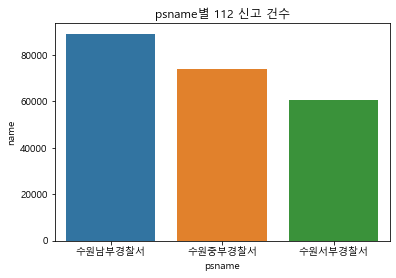

In [642]:
# 경찰서별 112 신고 건수
groupby_count(df_1, 'psname', 'name', sort='name', title='112 신고')

<AxesSubplot:title={'center':'case_type별 진주 112 건수'}, xlabel='case_type', ylabel='name'>

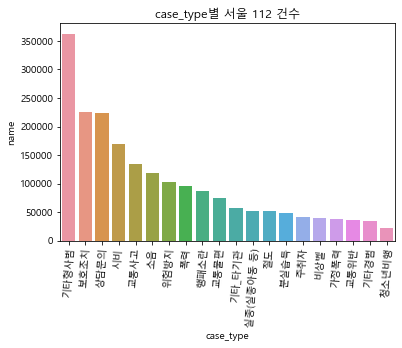

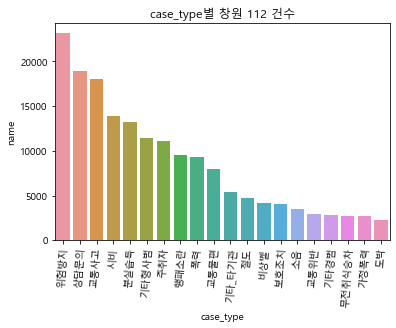

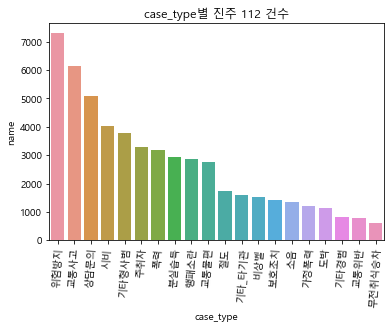

In [643]:
# 3개시 112 건수
groupby_count(df_3[df_3['sggname']=='서울'], 'case_type', 'name', sort='name', rotation=86, title='서울 112')
groupby_count(df_3[df_3['sggname']=='창원'], 'case_type', 'name', sort='name', rotation=86, title='창원 112')
groupby_count(df_3[df_3['sggname']=='진주'], 'case_type', 'name', sort='name', rotation=86, title='진주 112')

#### 수원시_시간대별_유동인구(2020)

In [644]:
df_4.head()

,STD_YM,TMST_00,TMST_01,TMST_02,TMST_03,TMST_04,TMST_05,TMST_06,TMST_07,TMST_08,TMST_09,TMST_10,TMST_11,TMST_12,TMST_13,TMST_14,TMST_15,TMST_16,TMST_17,TMST_18,TMST_19,TMST_20,TMST_21,TMST_22,TMST_23,lon,lat
0,202001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,126.92967,37.27015
1,202001,0.04000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.04000,0.04000,0.04000,0.04000,0.05000,0.05000,0.05000,0.05000,0.05000,0.05000,0.07000,0.07000,0.05000,0.05000,0.05000,0.04000,126.93023,37.27060
2,202001,0.05000,0.05000,0.04000,0.02000,0.02000,0.04000,0.04000,0.04000,0.05000,0.07000,0.07000,0.07000,0.07000,0.09000,0.09000,0.09000,0.11000,0.11000,0.12000,0.12000,0.11000,0.12000,0.11000,0.09000,126.93019,37.27601
3,202001,0.02000,0.02000,0.02000,0.00000,0.00000,0.00000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.02000,0.04000,0.04000,0.04000,0.04000,0.04000,0.04000,0.04000,0.02000,126.93136,37.26971
4,202001,0.02000,0.02000,0.00000,0.00000,0.00000,0.02000,0.02000,0.02000,0.07000,0.04000,0.05000,0.05000,0.07000,0.05000,0.07000,0.07000,0.07000,0.07000,0.09000,0.09000,0.07000,0.05000,0.05000,0.04000,126.93132,37.27557


In [645]:
df_4_mean = df_4.groupby(['lon', 'lat']).mean().reset_index()
df_4_mean.drop('STD_YM', axis=1, inplace=True)

def tmst(df):
    df_temp = df[['TMST_00', 'TMST_01', 'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05', 'TMST_06',
                  'TMST_07', 'TMST_08', 'TMST_09', 'TMST_10', 'TMST_11', 'TMST_12', 'TMST_13',
                  'TMST_14', 'TMST_15', 'TMST_16', 'TMST_17', 'TMST_18', 'TMST_19', 'TMST_20', 'TMST_21', 'TMST_22', 'TMST_23']]

df_4_temp = df_4_mean[['lon', 'lat', 'TMST_21', 'TMST_22', 'TMST_23']]
df_4_temp['TMST_MEAN'] = (df_4_temp['TMST_21'] + df_4_temp['TMST_22'] + df_4_temp['TMST_23'])/3

def field_(x):
    if 0<=x<1.511:
        return 0
    elif 1.511<=x<4.461:
        return 1
    elif 4.461<=x<8.419:
        return 2
    elif 8.419<=x<13.615:
        return 3
    elif 13.615<=x<20.747:
        return 4
    elif 20.747<=x<30.928:
        return 5
    elif 30.928<=x<45.569:
        return 6
    elif 45.569<=x<70.749:
        return 7
    elif 70.749<=x<128.069:
        return 8
    elif 128.069<=x<243.055:
        return 9
df_4_temp['TMST_FIELD'] = df_4_temp['TMST_MEAN'].apply(field_)

C:\Users\scoji\AppData\Local\Temp/ipykernel_14440/3393685696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4_temp['TMST_MEAN'] = (df_4_temp['TMST_21'] + df_4_temp['TMST_22'] + df_4_temp['TMST_23'])/3
C:\Users\scoji\AppData\Local\Temp/ipykernel_14440/3393685696.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4_temp['TMST_FIELD'] = df_4_temp['TMST_MEAN'].apply(field_)


#### 4개시도_유흥업소현황

In [646]:
df_8.head()

,STORE_ID,BUSINESS_NM,STORE_NM,COM_LC_CD,COM_LC_NM,COM_MC_CD,COM_MC_NM,COM_SC_CD,COM_SC_NM,KSIC_CD,KSIC_NM,SIDO_CD,SIDO_NM,SGG_CD,SGG_NM,ADB_EMD_CD,ADB_EMD_NM,EMD_CD,EMD_NM,JIBUN_CD,LAND_GBN_CD,LAND_GBN_NM,JIBUN_BON,JIBUN_BU,JIBUN_ADDR,ROAD_CD,ROAD_NM,BLDG_BON,BLDG_BU,BLDG_ID,BLDG_NM,ROAD_ADDR,OLD_ZIP_CODE,ZIP_CODE,DONG,FLOOR,HO,LON,LAT,geometry
0,20928658,채플린노래연습장,None,N,관광/여가/오락,N02,무도/유흥/가무,N02A01,노래방,R91223,노래연습장 운영업,41,경기도,41113,수원시 권선구,4111355000,평동,4111312900,오목천동,4111312900203130001,1,대지,313,1,경기도 수원시 권선구 오목천동 313-1,411134325235,경기도 수원시 권선구 삼천병마로1598번길,12,None,4111312900103130001035241,None,경기도 수원시 권선구 삼천병마로1598번길 12,441849,16635,None,1,None,126.96429,37.24533,POINT (126.96429 37.24533)
1,25447952,워커힐노래방,None,N,관광/여가/오락,N02,무도/유흥/가무,N02A01,노래방,R91223,노래연습장 운영업,41,경기도,41111,수원시 장안구,4111158000,영화동,4111113400,영화동,4111113400202760022,1,대지,276,22,경기도 수원시 장안구 영화동 276-22,411114322404,경기도 수원시 장안구 팔달로271번길,36,None,4111113400102760022040314,None,경기도 수원시 장안구 팔달로271번길 36,440818,16269,None,1,None,127.01367,37.29094,POINT (127.01367 37.29094)
2,25393963,왈츠노래방,None,N,관광/여가/오락,N02,무도/유흥/가무,N02A01,노래방,R91223,노래연습장 운영업,41,경기도,41115,수원시 팔달구,4111573000,인계동,4111514100,인계동,4111514100211230008,1,대지,1123,8,경기도 수원시 팔달구 인계동 1123-8,411154328471,경기도 수원시 팔달구 효원로291번길,28,None,4111514100111230008011564,이천빌딩,경기도 수원시 팔달구 효원로291번길 28,442835,16488,None,2,None,127.03431,37.26251,POINT (127.03431 37.26251)
3,20799982,락휴,None,N,관광/여가/오락,N02,무도/유흥/가무,N02A01,노래방,R91223,노래연습장 운영업,41,경기도,41117,수원시 영통구,4111755000,원천동,4111710200,원천동,4111710200200250002,1,대지,25,2,경기도 수원시 영통구 원천동 25-2,411173176009,경기도 수원시 영통구 아주로,18,None,4111710200100250002050245,None,경기도 수원시 영통구 아주로 18,443821,16502,None,4,4,127.04413,37.27638,POINT (127.04413 37.27638)
4,20846573,현대노래연습장,None,N,관광/여가/오락,N02,무도/유흥/가무,N02A01,노래방,R91223,노래연습장 운영업,41,경기도,41113,수원시 권선구,4111365000,구운동,4111313200,구운동,4111313200205180005,1,대지,518,5,경기도 수원시 권선구 구운동 518-5,411133175007,경기도 수원시 권선구 구운로,29,None,4111313200105180005026074,None,경기도 수원시 권선구 구운로 29,441819,16410,None,-1,None,126.97484,37.27693,POINT (126.97484 37.27693)


<AxesSubplot:title={'center':'FLOOR별 유흥업소 건수'}, xlabel='FLOOR', ylabel='BUSINESS_NM'>

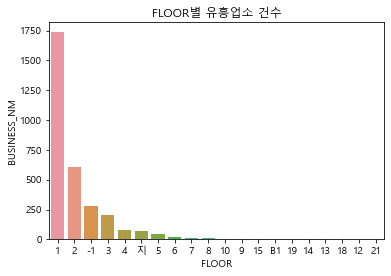

In [647]:
groupby_count(df_8, 'FLOOR', 'BUSINESS_NM', sort='BUSINESS_NM', title='유흥업소')

<AxesSubplot:title={'center':'SIDO_NM별 유흥업소 건수'}, xlabel='SIDO_NM', ylabel='BUSINESS_NM'>

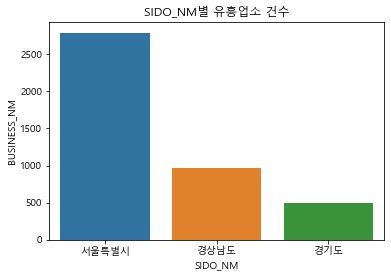

In [648]:
groupby_count(df_8, 'SIDO_NM', 'BUSINESS_NM', sort='BUSINESS_NM', title='유흥업소')

<AxesSubplot:title={'center':'SGG_NM별 유흥업소 건수'}, xlabel='SGG_NM', ylabel='BUSINESS_NM'>

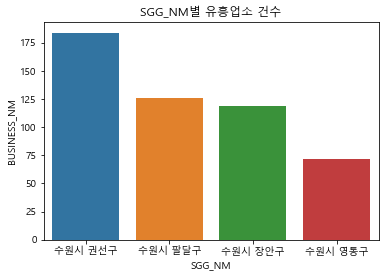

In [649]:
groupby_count(df_8[df_8['SIDO_NM']=='경기도'], 'SGG_NM', 'BUSINESS_NM', sort='BUSINESS_NM', title='유흥업소')

#### 4개시도_1인가구수

In [650]:
#33.4개시도_1인가구수
df_33.head()

,sido,sgg_nm,sx,age,date,single_person_hh,house_total_num,detached_house,apartment,townhouse,multiplex_house,house_in_commercial,not_in_house
0,서울특별시,종로구,계,합계,2017,23638,19260,11234,2992,887,3279,868,4378
1,서울특별시,종로구,계,20세 미만,2017,507,459,379,11,11,38,20,48
2,서울특별시,종로구,계,20~24,2017,2992,2519,1773,158,44,340,204,473
3,서울특별시,종로구,계,25~29,2017,3627,2845,1677,398,77,552,141,782
4,서울특별시,종로구,계,30~34,2017,2552,1970,1024,357,64,449,76,582


<AxesSubplot:title={'center':'sido별 1인가구 합계'}, xlabel='sido', ylabel='single_person_hh'>

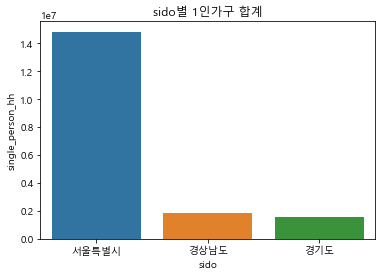

In [651]:
groupby_sum(df_33, 'sido', 'single_person_hh', sort='single_person_hh', title='1인가구')


<AxesSubplot:title={'center':'sgg_nm별 1인가구 합계'}, xlabel='sgg_nm', ylabel='single_person_hh'>

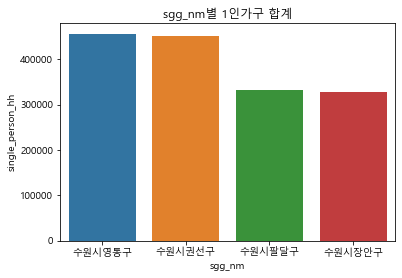

In [652]:
groupby_sum(df_33[df_33['sido']=='경기도'], 'sgg_nm', 'single_person_hh', sort='single_person_hh', title='1인가구')

#### 건축물대장_표제부  데이터

In [653]:
df_26 = pd.read_excel(file_path + '26.수원시_건축물대장(표제부).xlsx')

In [654]:
df_26_new  = df_26[[
                                    'mgm_bldrgst_pk', # 건축물 관리 대장 Pk  (아이디)
                                     'new_plat_plc',        # 도로명대지위치
                                    'bld_nm',   # 건물명
                                     'splot_nm', # 특수지명 
                                     'na_bjdong_cd',   # 새주소법정동코드      
                                    'plat_area'  ,  #    대지면적(㎡)
                                    'arch_area' ,   #건축면적(㎡)
                                    'bc_rat'  ,    #    건폐율(%)
                                    'tot_area',  #    연면적(㎡)
                                    'vl_rat_estm_tot_area\t' , #   용적률산정연면적(㎡)
                                    'vl_rat'  , #   용적률(%)
                                    'main_purps_cd_nm' , # 주용도코드명
                                    'etc_purps' , # 기타용도
                                    'hhld_cnt', # 세대수(세대)
                                    'fmly_cnt', # 가구수(가구)
                                    'heit',  # 높이
                                    'grnd_flr_cnt' ,  #  지상층수
                                    'ugrnd_flr_cnt',  #   지하층수'
                                    'use_apr_day' #사용승인일            
                   ]]

- 변수 이름 수정 

In [655]:
df_26_new.rename(columns = {'vl_rat_estm_tot_area\t' : 'vl_rat_estm_tot_area'}, inplace  = True)

C:\ProgramData\Anaconda3\envs\compas_suwon\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


- 도로명 주소 공백 제거

In [656]:
df_26_new['new_plat_plc']  = df_26_new['new_plat_plc'].str.lstrip()

C:\Users\scoji\AppData\Local\Temp/ipykernel_14440/1500569948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_26_new['new_plat_plc']  = df_26_new['new_plat_plc'].str.lstrip()


- 변수 타입 수정 

In [657]:
df_26_new.reset_index(drop= True, inplace = True)

- 도로명주소가 공백인 행 --> 제거
- 사용승인일  결측치인 행 --> 제거 

In [658]:
df_26_new  = df_26_new[df_26_new['new_plat_plc'].str.contains('수원')]
df_26_new.dropna(subset = ['use_apr_day'], axis = 0 , inplace =True)

In [659]:
df_26_new['use_apr_day'] = df_26_new['use_apr_day'].astype(str)

In [660]:
df_26_new['use_apr_YEAR'] = df_26_new['use_apr_day'].str.slice(start=0, stop= 4)

In [661]:
df_26_new['use_apr_YEAR']   = pd.to_numeric(df_26_new['use_apr_YEAR'])

- 인덱스 초기화

In [662]:
df_26_new.reset_index(drop= True, inplace = True)

#### 파생변수 생성 

- 1. 건물연한

In [663]:
df_26_new['OLD_YEAR'] =   2021 - df_26_new['use_apr_YEAR']

- 2. 노후도 (OLD_LEVEL) 

In [664]:
def cal_old_level(year) :
    if               year < 10:
        return 1
    elif 10 <= year < 20: 
        return 2
    elif 20 <= year < 30:
        return 3
    else: 
        return 4

In [665]:
df_26_new['OLD_LEVEL'] = df_26_new['OLD_YEAR'].apply(cal_old_level)

- 주소 geometry 부여 

In [666]:
df_26_new['lat'] = '-'
df_26_new['lon'] = '-'

<b>
** 도로명주소를 개인 Google API로 변환하는 과정은 
개인 API 정보 및 시간 소요 관계상 주석 처리
<b>

In [667]:
# gmaps = googlemaps.Client(key='개인 구글 API Key')
# for i in range(len(df_26_new['new_plat_plc'])):

#     geocode_result = gmaps.geocode(df_26_new['new_plat_plc'][i], language='ko')
    
#     # 도로명주소 변환 안되는 케이스
#     if len(geocode_result) == 0:   
#         df_26_new['lat'][i] = 0
#         df_26_new['lon'][i] = 0

#     else:   
#         df_26_new['lat'][i] = geocode_result[0]['geometry']['location']['lat']
#         df_26_new['lon'][i] = geocode_result[0]['geometry']['location']['lng']
#     print(i,  '번째 행 완료')

#### 격자별 노후건물면적비율 , 상가역할건물면적비율 도출 

In [668]:
building_grid = pd.read_csv(file_path + 'building_grid.csv')

In [669]:
building_grid.head(5)

,mgm_bldrgst_pk,new_plat_plc,bld_nm,splot_nm,na_bjdong_cd,plat_area,arch_area,bc_rat,tot_area,vl_rat_estm_tot_area,vl_rat,main_purps_cd_nm,etc_purps,hhld_cnt,fmly_cnt,heit,grnd_flr_cnt,ugrnd_flr_cnt,use_apr_day,use_apr_YEAR,OLD_YEAR,OLD_LEVEL,jibun,lat,lon,gid
0,41117-100294729,경기도 수원시 영통구 중부대로 384,매탄동 고속주유소,NaN,10101,0.00000,214.40000,0.00000,285.60000,285.60000,0.00000,제2종근린생활시설,제2종근린생활시설(수리점),0,0,8.10000,2,0,20140117,2014,7,1,경기도 수원시 영통구 매탄동 1-1,37.27124,127.05741,다사60bb19aa
1,41117-100342541,경기도 수원시 영통구 중부대로 384,매탄동 고속주유소,NaN,10101,0.00000,229.92000,0.00000,229.92000,229.92000,0.00000,자동차관련시설,자동차관련시설(세차장),0,0,3.90000,1,0,20160309,2016,5,1,경기도 수원시 영통구 매탄동 1-1,37.27124,127.05741,다사60bb19aa
2,41117-100294730,경기도 수원시 영통구 중부대로 384,매탄동 고속주유소,NaN,10101,3480.00000,103.50000,2.97000,103.50000,103.50000,2.97000,위험물저장및처리시설,위험물저장및처리시설(자동세차기),0,0,5.60000,1,0,20140117,2014,7,1,경기도 수원시 영통구 매탄동 1-1,37.27124,127.05741,다사60bb19aa
3,41117-100294728,경기도 수원시 영통구 중부대로 384,매탄동 고속주유소,NaN,10101,3480.00000,366.48000,10.53000,449.06000,449.06000,12.90000,위험물저장및처리시설,"위험물저장및처리시설,제1종근린생활시설",0,0,7.75000,2,0,20140117,2014,7,1,경기도 수원시 영통구 매탄동 1-1,37.27124,127.05741,다사60bb19aa
4,41117-100341931,경기도 수원시 영통구 중부대로 390,NaN,NaN,10101,2743.00000,1501.54000,54.74000,9301.72000,4921.04000,179.40000,문화및집회시설,"문화및집회시설(전시장),판매시설(상점)",0,0,21.50000,4,2,20160222,2016,5,1,경기도 수원시 영통구 매탄동 1-7,37.27102,127.05781,다사60bb19aa


- 각 격자의 면적 = 62500 m²

In [670]:
building_grid['grid_area'] = 62500

-  노후건물면적비율 = (노후 건물(lv 4 )의 대지면적) / 관할면적 

노후건물 필터링

In [671]:
old_building = building_grid[building_grid['OLD_LEVEL'] == 4]

In [672]:
old_building_gr  = old_building.groupby(by = 'gid').count().reset_index()

- 노후도가 4인 건물들의 대지면접 합 

In [673]:
old_plat_area = old_building.groupby(by = 'gid').sum().reset_index()[['gid', 'plat_area']]

In [674]:
old_plat_area['grid_area'] =  62500

In [675]:
old_plat_area['old_area_ratio'] =  old_plat_area['plat_area'] / old_plat_area['grid_area'] 
old_plat_area.rename(columns = {'plat_area' : 'old_plat_area'}, inplace =True)
old_plat_area

-  (상가 역할 건물의 대지면적)  / 관할면적 

- 상가역할 건물 : 제1종근린생활시설, 제2종근린생활시설, 판매시설, 판매및영업시설  로 정의

In [679]:
sangga_types = ['제1종근린생활시설', '제2종근린생활시설','판매시설','판매및영업시설']

In [680]:
sangga  = building_grid[building_grid['main_purps_cd_nm'].isin(sangga_types) ]

In [681]:
sangga_gr =  sangga.groupby(by = 'gid').count().reset_index()

### 상가역할 건물들의 대지면접 합 

In [682]:
sangga_area= sangga.groupby(by = 'gid').sum().reset_index()[['gid', 'plat_area']]

In [683]:
sangga_area['grid_area'] =  62500

In [684]:
sangga_area['sangga_area_ratio'] =  sangga_area['plat_area'] / sangga_area['grid_area'] 
sangga_area.rename(columns = {'plat_area' : 'sangga_plat_area'}, inplace =True)

In [685]:
sangga_area

,gid,sangga_plat_area,grid_area,sangga_area_ratio
0,다사49bb19aa,330.00000,62500,0.00528
1,다사49bb19ba,320.00000,62500,0.00512
2,다사49bb19bb,327.00000,62500,0.00523
3,다사50aa18bb,2770.00000,62500,0.04432
4,다사50aa19aa,5259.00000,62500,0.08414
...,...,...,...,...
974,다사62ba20bb,1918.30000,62500,0.03069
975,다사62bb16bb,1240.00000,62500,0.01984
976,다사62bb18ba,4850.30000,62500,0.07760
977,다사63aa18ab,0.00000,62500,0.00000


In [686]:
building_area_data = pd.merge(old_plat_area, sangga_area[['gid','sangga_plat_area','sangga_area_ratio']], on = 'gid' , how = 'outer' )
building_area_data = building_area_data.fillna(0)
building_area_data

,gid,old_plat_area,grid_area,old_area_ratio,sangga_plat_area,sangga_area_ratio
0,다사49ba19bb,0.00000,62500.00000,0.00000,0.00000,0.00000
1,다사49bb19ba,0.00000,62500.00000,0.00000,320.00000,0.00512
2,다사49bb20ba,0.00000,62500.00000,0.00000,0.00000,0.00000
3,다사49bb20bb,0.00000,62500.00000,0.00000,0.00000,0.00000
4,다사50aa20ba,0.00000,62500.00000,0.00000,844.00000,0.01350
...,...,...,...,...,...,...
1046,다사62ba20bb,0.00000,0.00000,0.00000,1918.30000,0.03069
1047,다사62bb16bb,0.00000,0.00000,0.00000,1240.00000,0.01984
1048,다사62bb18ba,0.00000,0.00000,0.00000,4850.30000,0.07760
1049,다사63aa18ab,0.00000,0.00000,0.00000,0.00000,0.00000


In [687]:
building_area_grid_only_ratio  = building_area_data[['gid' , 'old_area_ratio', 'sangga_area_ratio']]

,gid,old_area_ratio,sangga_area_ratio
0,다사49ba19bb,0.00000,0.00000
1,다사49bb19ba,0.00000,0.00512
2,다사49bb20ba,0.00000,0.00000
3,다사49bb20bb,0.00000,0.00000
4,다사50aa20ba,0.00000,0.01350
...,...,...,...
1046,다사62ba20bb,0.00000,0.03069
1047,다사62bb16bb,0.00000,0.01984
1048,다사62bb18ba,0.00000,0.07760
1049,다사63aa18ab,0.00000,0.00000


- 수원시 전체 표준격자 데이터로 조인 

In [688]:
suwon_grid = pd.read_csv(file_path + '수원시_표준격자.csv', encoding = 'utf-8')
suwon_grid = suwon_grid[['gid']]

,gid
0,다사49aa19ab
1,다사49aa19ba
2,다사49aa20aa
3,다사49ab18ab
4,다사49ab18ba
...,...
2085,다사63ba21aa
2086,다사63ba21ab
2087,다사63ba21ba
2088,다사63ba21bb


In [689]:
building_area_grid = pd.merge(suwon_grid , building_area_grid_only_ratio , on = 'gid', how = 'left')
building_area_grid = building_area_grid.fillna(0)
building_area_grid

# 3. 모델링

## 3.1 격자별 클러스터링 

### 격자별 보안등 분포 데이터

In [691]:
boan_grid = pd.read_csv(file_path+'격자별_보안등.csv' , encoding = 'utf-8') 

### 격자별 CCTV 분포 데이터

In [692]:
cctv_grid = pd.read_csv(file_path+'격자별_cctv.csv' , encoding = 'utf-8') 

### 격자별 가로등 분포 데이터

In [693]:
garo_grid = pd.read_csv(file_path+'격자별_가로등.csv' , encoding = 'utf-8') 

### 격자별 노후건물면적비율, 상가건물면적비율 데이터

In [694]:
building_grid =  pd.read_csv(file_path+'격자별_건물면적.csv' , encoding = 'utf-8') 

### 격자별 112 신고건수 데이터 

In [695]:
oneonetwo_grid =  pd.read_csv(file_path+'격자별_112신고건수.csv' , encoding = 'utf-8' ) 
oneonetwo_grid = oneonetwo_grid[['gid', 'cnt_112']]

### 클러스터링 용 데이터 통합

In [696]:
total_data_for_clustering = pd.merge(garo_grid, boan_grid , on = 'gid' , how = 'inner' )

In [697]:
total_data_for_clustering= pd.merge(total_data_for_clustering, building_grid , on = 'gid' , how = 'inner' )

In [698]:
total_data_for_clustering = pd.merge(total_data_for_clustering, cctv_grid , on = 'gid' , how = 'inner' )

In [699]:
total_data_for_clustering = pd.merge(total_data_for_clustering, oneonetwo_grid,   on = 'gid' , how = 'inner')

In [700]:
total_data_for_clustering

,gid,cnt_light,total_cnt_securitylight,old_area_ratio,sangga_area_ratio,cnt_cctv,cnt_112
0,다사49aa19ab,0,0,0.00000,0.00000,0,0.00000
1,다사49aa19ba,0,0,0.00000,0.00000,0,0.00000
2,다사49aa20aa,0,0,0.00000,0.00000,0,0.00000
3,다사49ab18ab,0,0,0.00000,0.00000,0,0.00000
4,다사49ab18ba,0,0,0.00000,0.00000,0,0.00000
...,...,...,...,...,...,...,...
2085,다사63ba21aa,0,0,0.00000,0.00000,0,0.00000
2086,다사63ba21ab,0,0,0.00000,0.00000,0,0.00000
2087,다사63ba21ba,0,0,0.00000,0.00000,0,0.00000
2088,다사63ba21bb,2,0,0.00000,0.00000,0,0.00000


### 클러스터링

In [701]:
X = total_data_for_clustering.loc[ :, [ 'cnt_light' , 'total_cnt_securitylight',  'old_area_ratio',  'sangga_area_ratio' , 'cnt_cctv', 'cnt_112'  ]]

#### 변수 스케일링 : Standard Scaler 

In [702]:
standardScaler = StandardScaler()
print(standardScaler.fit(X))
X = standardScaler.transform(X)

StandardScaler()


In [703]:
X

array([[-0.83072421, -0.49891291, -0.07179982, -0.18492806, -0.69257792,
        -0.41567539],
       [-0.83072421, -0.49891291, -0.07179982, -0.18492806, -0.69257792,
        -0.41567539],
       [-0.83072421, -0.49891291, -0.07179982, -0.18492806, -0.69257792,
        -0.41567539],
       ...,
       [-0.83072421, -0.49891291, -0.07179982, -0.18492806, -0.69257792,
        -0.41567539],
       [-0.68869684, -0.49891291, -0.07179982, -0.18492806, -0.69257792,
        -0.41567539],
       [-0.83072421, -0.49891291, -0.07179982, -0.18492806, -0.69257792,
        -0.41567539]])

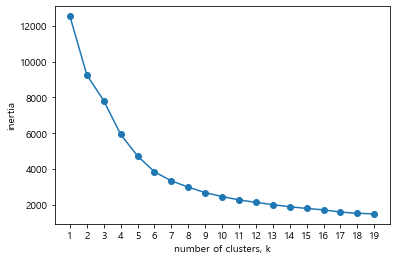

In [704]:
ks = range(1,20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X)
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

plt.show()


-  Elbow Method 및 k = 5, k= 7, k= 10일때의 결과 비교를 통해  클러스터 갯수는 10개로 선정


In [705]:
Kmean = KMeans(n_clusters= 10 )
Kmean.fit(X)
Kmean.labels_
result = pd.Series(Kmean.labels_)

In [706]:
result.value_counts()

1    1053
7     428
9     204
0     141
2     137
8     104
3      14
5       6
4       2
6       1
dtype: int64

In [707]:
clustered_grid =  pd.concat([total_data_for_clustering, result] , axis = 1)
clustered_grid.rename(columns = {0 : '클러스터'}, inplace = True)
clustered_grid

,gid,cnt_light,total_cnt_securitylight,old_area_ratio,sangga_area_ratio,cnt_cctv,cnt_112,클러스터
0,다사49aa19ab,0,0,0.00000,0.00000,0,0.00000,1
1,다사49aa19ba,0,0,0.00000,0.00000,0,0.00000,1
2,다사49aa20aa,0,0,0.00000,0.00000,0,0.00000,1
3,다사49ab18ab,0,0,0.00000,0.00000,0,0.00000,1
4,다사49ab18ba,0,0,0.00000,0.00000,0,0.00000,1
...,...,...,...,...,...,...,...,...
2085,다사63ba21aa,0,0,0.00000,0.00000,0,0.00000,1
2086,다사63ba21ab,0,0,0.00000,0.00000,0,0.00000,1
2087,다사63ba21ba,0,0,0.00000,0.00000,0,0.00000,1
2088,다사63ba21bb,2,0,0.00000,0.00000,0,0.00000,1


### 각 클러스터 별 변수 평균치 확인

In [708]:
cluster_level = clustered_grid.groupby(by = '클러스터').mean().reset_index()
cluster_level

,클러스터,cnt_light,total_cnt_securitylight,old_area_ratio,sangga_area_ratio,cnt_cctv,cnt_112
0,0,10.26241,46.04255,0.07383,0.07151,24.90071,258.36170
1,1,1.71415,1.20323,0.00333,0.00907,0.75404,10.00095
2,2,22.32847,26.42336,0.05989,0.10163,13.04380,444.33577
3,3,19.57143,14.42857,0.07248,0.30145,17.71429,2179.35714
4,4,9.50000,0.50000,11.97019,0.02438,3.00000,37.00000
5,5,18.83333,0.16667,0.00000,2.42906,4.83333,43.33333
6,6,8.00000,0.00000,0.00000,8.88574,6.00000,9.00000
7,7,22.12617,1.93458,0.00758,0.03626,3.57710,67.96963
8,8,48.25962,2.21154,0.01932,0.07272,11.37500,121.70192
9,9,15.85784,8.44118,0.02998,0.06850,14.64706,122.88725


### 클러스터별 112 신고건수 

In [709]:
onetonetwo_grid_raw = pd.read_csv(file_path+'1.수원시_112신고이력(격자_관할경계매핑).csv' , encoding = 'utf-8', index_col =0) 

C:\ProgramData\Anaconda3\envs\compas_suwon\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [710]:
clustered_grid_table = clustered_grid[['gid','클러스터']]

In [711]:
oot_cluster = pd.merge(onetonetwo_grid_raw, clustered_grid_table , on = 'gid' , how = 'left')

In [712]:
oot_cluster.rename(columns = {'case_type' : 'case'} , inplace = True)

In [713]:
oot_cluster.columns = ['case', 'rec_date','rec_time','arrival_date','gid','name','psname','클러스터']  

In [714]:
oot_cluster

,case,rec_date,rec_time,arrival_date,gid,name,psname,클러스터
0,비상벨,20200101,183945',NaN,다사56aa19ab,고등파출소,수원서부경찰서,0
1,기타_타기관,20200101,012615',20200101014135.00000,다사58ab18ba,인계파출소,수원남부경찰서,3
2,폭력,20200101,005151',20200101005314.00000,다사56bb21aa,화서문지구대,수원중부경찰서,2
3,소음,20200101,012608',20200101013131.00000,다사57aa17ba,세류지구대,수원남부경찰서,0
4,분실습득,20200101,014719',NaN,다사59bb21aa,광교지구대,수원남부경찰서,7
...,...,...,...,...,...,...,...,...
223759,폭력,20201231,231029',20201231231254,다사55aa23aa,노송지구대,수원중부경찰서,2
223760,상담문의,20201230,132805',20201230132821,다사54ba23ba,노송지구대,수원중부경찰서,2
223761,폭력,20201231,230742',20201231231124,다사54ba23ab,노송지구대,수원중부경찰서,9
223762,상담문의,20201231,220135',NaN,다사54bb23ab,노송지구대,수원중부경찰서,0


In [715]:
oot_cluster_gr  =oot_cluster.groupby(['클러스터', 'case'] ).count()
oot_cluster_gr

rec_date  rec_time  arrival_date   gid  name  psname
클러스터 case                                                        
0    가정폭력        1530      1530          1470  1530  1530    1530
     교통불편        1037      1037           990  1037  1037    1037
     교통사고        3090      3090          2938  3090  3090    3090
     교통위반         310       310           298   310   310     310
     기타_타기관      1051      1051           895  1051  1051    1051
...               ...       ...           ...   ...   ...     ...
9    위험방지        3363      3363          3226  3363  3363    3363
     절도           752       752           726   752   752     752
     주취자          967       967           949   967   967     967
     폭력          1041      1041           993  1041  1041    1041
     행패소란         753       753           724   753   753     753

[182 rows x 6 columns]

# 3.2 1번 클러스터 CCTV 최적위치 모델링

### 데이터 불러오기

####  Clients : shop

In [716]:
shop = pd.read_csv(file_path+'/클러스터1(건물-cctv).csv',encoding='utf-8')
display(shop.head())
shop.shape

,gid,클러스터,lon,lat
0,다사58ab21ba,1,127.02978,37.29238
1,다사58ab21ba,1,127.03006,37.29253
2,다사58ab21ba,1,127.02979,37.29256
3,다사58ab21ba,1,127.03003,37.29261
4,다사58ab21ba,1,127.02995,37.29272


(2560, 4)

In [717]:
#좌표로 포인트 생성 (but, 현재는 필요없는 코드)
#가져온 데이터가 기존에 5179좌표계여서 set_crs만 진행
shop = geopandas.GeoDataFrame(shop, geometry=geopandas.points_from_xy(shop['lon'], shop['lat']))
shop.set_crs(epsg = 5179, inplace = True)
shop.head(2)

,gid,클러스터,lon,lat,geometry
0,다사58ab21ba,1,127.02978,37.29238,POINT (127.02978 37.29238)
1,다사58ab21ba,1,127.03006,37.29253,POINT (127.03006 37.29253)


### 데이터 시각화
#### Clients points

<AxesSubplot:>

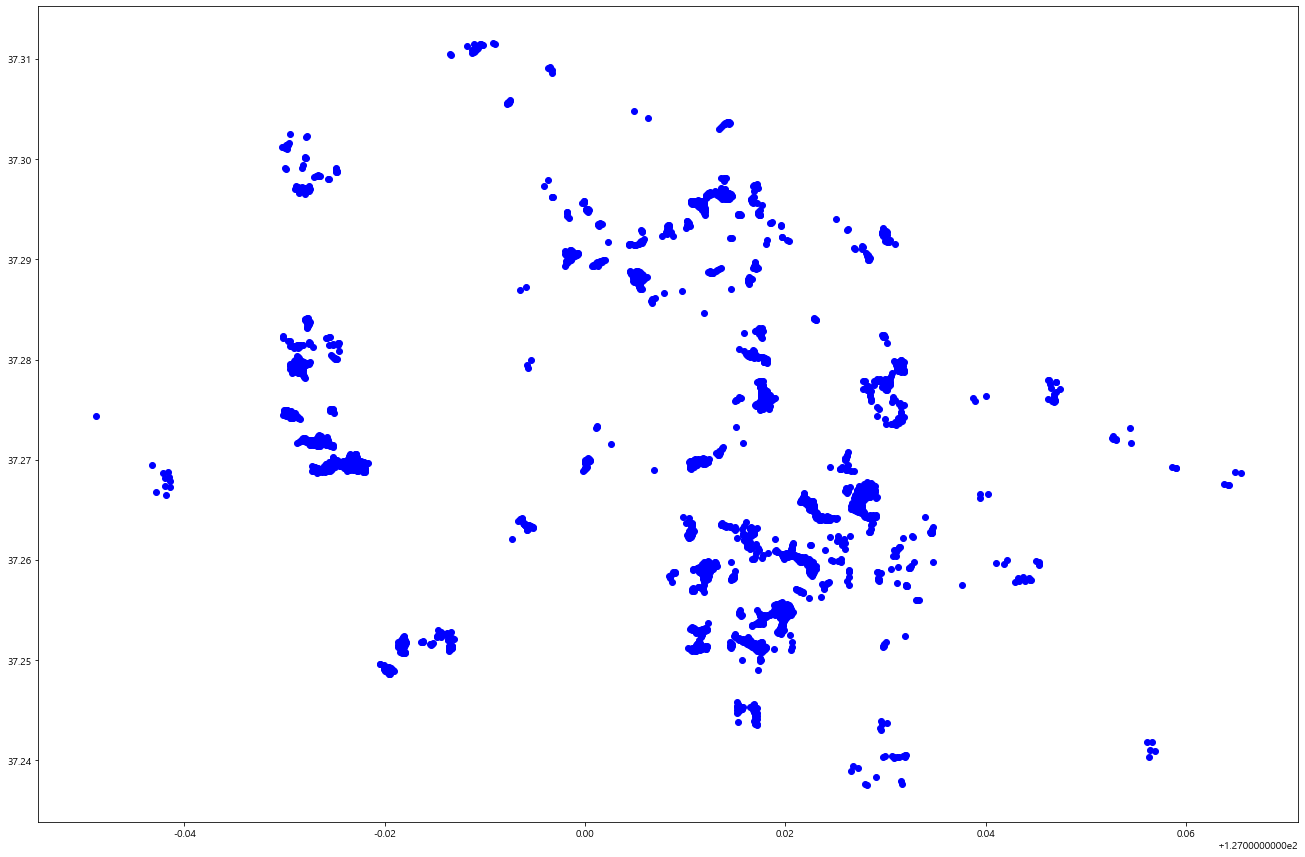

In [718]:
shop.plot(color='blue', figsize=(45,15))

### 모델 정의

In [719]:
def generate_candidate_sites(points,M=100):
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

In [720]:
def mclp(points,K,radius,M):
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(points,M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [721]:
def plot_input(points):
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)



In [722]:
def plot_result(points,opt_sites,radius):
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(15,15))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)
    print(opt_sites)


<AxesSubplot:>

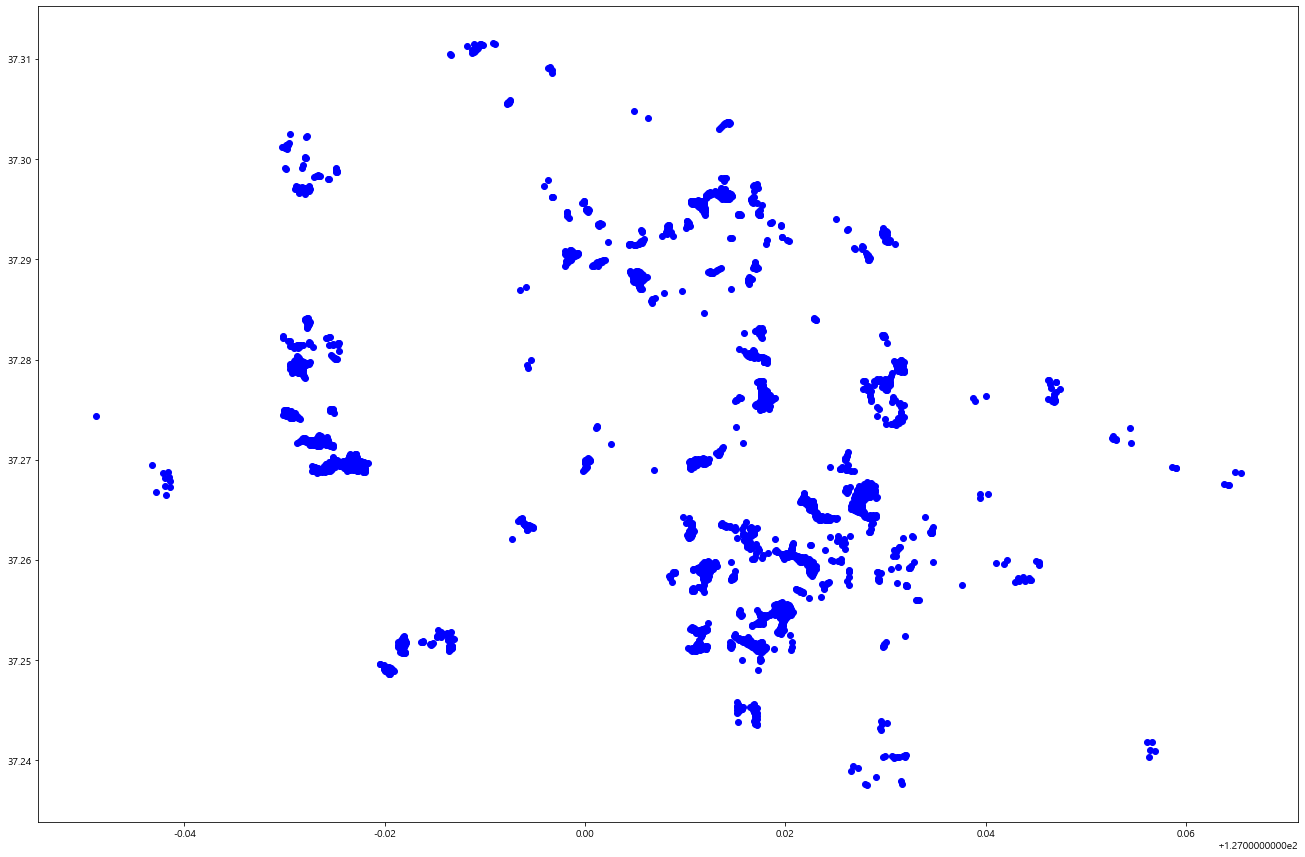

In [723]:
shop.plot(color='blue', figsize=(45,15))

In [724]:
shop.shape

(2560, 5)

In [725]:
# data 전처리
points=[]
for i in range(shop.shape[0]) :
    points.append([shop['lon'][i], shop['lat'][i]])

In [726]:
#input 형태로 변환
points=np.array(points)

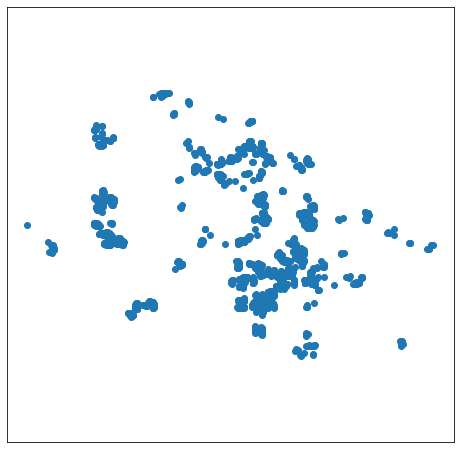

In [727]:
# 데이터 시각화와 같게 나오는지 확인
plot_input(points)

### 모델 변수 정의

In [728]:
# 몇 개를 만들 것인가
K = 10

# 중심점을 기준으로 몇 km를 반지름으로 하여 커버 가능한가 (위도 1도가 111km)
radius = 0.00091 #약 100m는 0.00091도

# 얼마나 많은 후보들 중 고를 것인가
M = 10000

# Run mclp opt_sites is the location of optimal sites and f is the points covered
# opt_sites,f = mclp(points,K,radius,M)

# 결과 시각화
# plot_result(points,opt_sites,radius)


- <b>결과 시각화는GUROBI  라이센스가 인증된 로컬환경에서만 구동되는 관계로, 결과 캡처본을 아래에 첨부
    

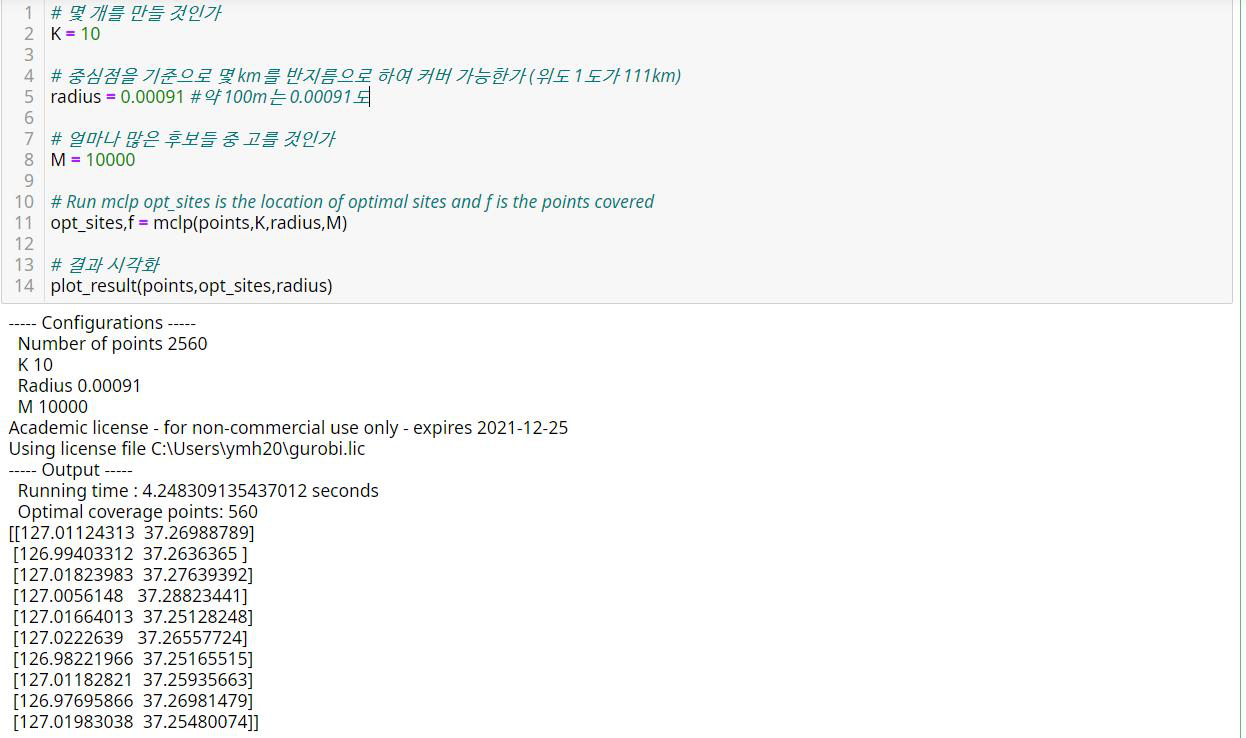

In [729]:
Image.open(file_path + 'gurobi_result_points.jpg' , mode = 'r')

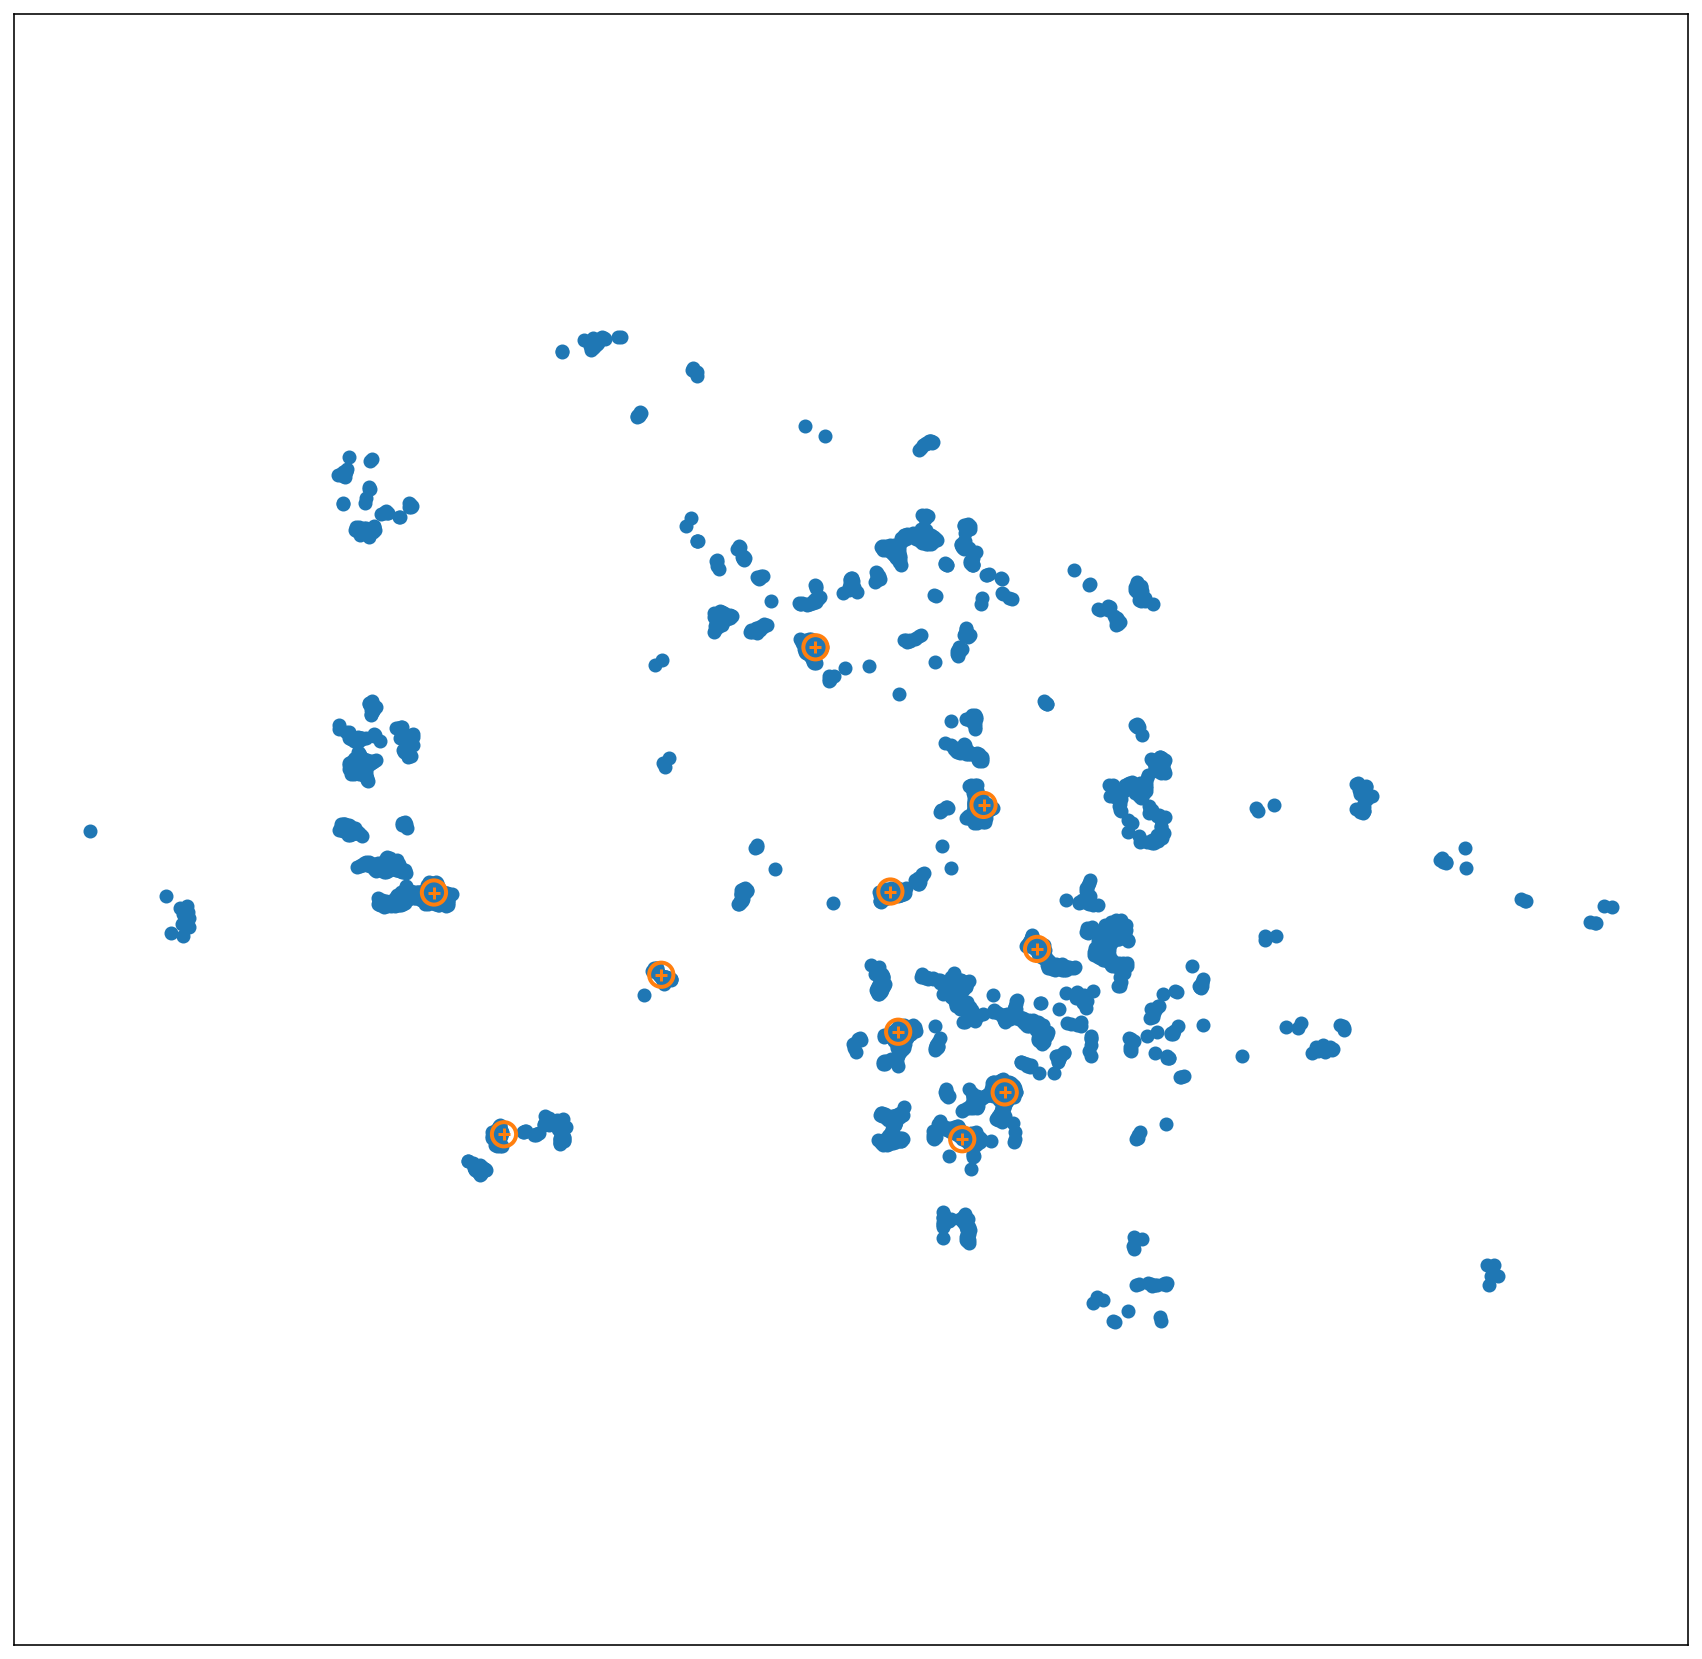

In [730]:
Image.open(file_path+ 'gurobi_result_points_pic.png' , mode = 'r')